In [4]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Hyper Parameters
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = False

In [3]:
train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),   # (0, 255) 的数据压缩成 [0, 1]
    download=DOWNLOAD_MNIST,
)


100.1%

Extracting ./mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./mnist\MNIST\raw


113.5%

Extracting ./mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist\MNIST\raw


100.4%

Extracting ./mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist\MNIST\raw


180.4%

Extracting ./mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist\MNIST\raw
Processing...


D:\anaconda3\envs\dl_env\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


torch.Size([60000, 28, 28])
torch.Size([60000])


<function matplotlib.pyplot.show(close=None, block=None)>

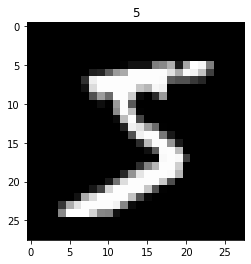

In [14]:
# plot sample data
print(train_data.data.size())
print(train_data.targets.size())

plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title(f'{train_data.targets[0]}')
plt.show

In [47]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
# load test data
test_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=False,
)
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000]/255
test_y = test_data.targets[:2000]

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential( # (1, 28, 28)
            nn.Conv2d(              
                in_channels=1,      # input 高度，如 RGB 图片为 3， 灰度图片 为 1
                out_channels=16,    # output 高度，每个窗口生成多少个特征
                kernel_size=5,      # 每个窗口（正方形）的边长
                stride=1,           # 每次扫描后跳多少像素点
                padding=2,          # 外围填充多少圈。若 stride=1, padding=(kernel_size-1)/2, 则 input 和 output 的长宽一致 
            ),                      # -> (16, 28, 28)
            nn.ReLU(),              # -> (16, 28, 28)
            nn.MaxPool2d(kernel_size=2),    # -> (16, 14, 14)
        )
        self.conv2 = nn.Sequential(       # (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),   # -> (32, 14, 14)
            nn.ReLU(),                    # -> (32, 14, 14)
            nn.MaxPool2d(2)               # -> (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):             # x : (batch, 1, 28, 28)
        x = self.conv1(x)             # -> (batch, 16, 14, 14)
        x = self.conv2(x)             # -> (batch, 32, 7, 7)
        x = x.view(x.size(0), -1)     # -> (batch, 32 * 7 * 7)
        output = self.out(x)
        return output


In [49]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [50]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [56]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, ' | Step: ', step, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0  | Step:  0 | train loss: 2.3184 | test accuracy: 0.14
Epoch:  0  | Step:  50 | train loss: 0.2876 | test accuracy: 0.84
Epoch:  0  | Step:  100 | train loss: 0.4260 | test accuracy: 0.91
Epoch:  0  | Step:  150 | train loss: 0.1727 | test accuracy: 0.93
Epoch:  0  | Step:  200 | train loss: 0.1560 | test accuracy: 0.94
Epoch:  0  | Step:  250 | train loss: 0.0862 | test accuracy: 0.95
Epoch:  0  | Step:  300 | train loss: 0.1266 | test accuracy: 0.95
Epoch:  0  | Step:  350 | train loss: 0.1585 | test accuracy: 0.96
Epoch:  0  | Step:  400 | train loss: 0.1832 | test accuracy: 0.96
Epoch:  0  | Step:  450 | train loss: 0.0597 | test accuracy: 0.96
Epoch:  0  | Step:  500 | train loss: 0.1178 | test accuracy: 0.96
Epoch:  0  | Step:  550 | train loss: 0.1151 | test accuracy: 0.97
Epoch:  0  | Step:  600 | train loss: 0.0314 | test accuracy: 0.97
Epoch:  0  | Step:  650 | train loss: 0.1649 | test accuracy: 0.97
Epoch:  0  | Step:  700 | train loss: 0.0807 | test accuracy: 0.9

In [57]:
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, ' prediction number')
print(test_y[:10].numpy(), ' real number')

[7 2 1 0 4 1 4 9 5 9]  prediction number
[7 2 1 0 4 1 4 9 5 9]  real number
